In [154]:
# importing libraries
import pandas as pd
import scipy
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [155]:
# Load the dataset
df = pd.read_csv('bookings_train.csv')
print(df.head())
df.info()
df.isnull().sum()

                                 booking_id  citizen_id booking_date  \
0  f7b59ba3793fea61282cb02be2247cebd0a75306  4229044420   2021-01-01   
1  cfe30d53b4b645e4cb6b114f6c9d74a0f25e6a80  5389442635   2021-01-01   
2  0fb0a5d9b3944dd743a9e7828dc03fa74aa6ebf8  2123783919   2021-01-01   
3  d4bf826153212fa325ad98b215668ab942365607  6359918966   2021-01-01   
4  ebb4c9687acbaf65376d8e379bd1341d1c15127e   178732202   2021-01-01   

  appointment_date appointment_time        check_in_time  \
0       2021-01-01            09:03  2021-01-01 09:11:00   
1       2021-01-01            09:12  2021-01-01 09:24:00   
2       2021-01-01            09:36  2021-01-01 09:29:00   
3       2021-01-01            09:45  2021-01-01 10:07:00   
4       2021-01-01            10:12  2021-01-01 10:26:00   

                  check_out_time   task_id  num_documents  queue_number  \
0  2021-01-01 09:48:15.166353269  TASK-002              0             2   
1  2021-01-01 10:24:12.189261137  TASK-001              

booking_id                0
citizen_id                0
booking_date              0
appointment_date          0
appointment_time          0
check_in_time          6092
check_out_time         6092
task_id                   0
num_documents             0
queue_number              0
satisfaction_rating       0
dtype: int64

In [156]:
df.describe()

,citizen_id,num_documents,queue_number,satisfaction_rating
count,2.036930e+05,203693.000000,203693.000000,203693.000000
mean,4.996145e+09,2.436790,9.310511,4.187277
std,2.880985e+09,1.734511,8.245711,0.463539
min,4.318100e+04,0.000000,1.000000,3.000000
25%,2.504323e+09,1.000000,3.000000,4.000000
50%,4.995536e+09,2.000000,7.000000,4.000000
75%,7.491514e+09,3.000000,13.000000,4.000000
max,9.999975e+09,14.000000,133.000000,5.000000


In [157]:
#Parse basic date/time columns
df['booking_date'] = pd.to_datetime(df['booking_date'], errors='coerce')
df['appointment_date'] = pd.to_datetime(df['appointment_date'], errors='coerce')

# Parse appointment_time and create appointment_datetime for feature engineering
# Input format is HH:MM (24h)
df['appointment_time'] = pd.to_datetime(df['appointment_time'], format='%H:%M', errors='coerce').dt.time

df['appointment_datetime'] = pd.to_datetime(
    df['appointment_date'].dt.strftime('%Y-%m-%d') + ' ' + df['appointment_time'].astype(str),
    errors='coerce'
)

# Parse check-in/out timestamps
df['check_in_time'] = pd.to_datetime(df['check_in_time'], errors='coerce')
df['check_out_time'] = pd.to_datetime(df['check_out_time'], errors='coerce')

# Compute processing time in minutes (target)
df['processing_time_minutes'] = (
    df['check_out_time'] - df['check_in_time']
).dt.total_seconds() / 60.0

# Keep only reasonable, present targets (exclude missing, non-positive, or > 8 hours)
valid_mask = (
    df['processing_time_minutes'].notna()
    & (df['processing_time_minutes'] > 0)
    & (df['processing_time_minutes'] < 480)
)

df_task1 = df.loc[valid_mask].copy()
print('Rows before:', len(df), '| After Task 1 filtering:', len(df_task1))

df_task1[['processing_time_minutes']].describe()


Rows before: 203693 | After Task 1 filtering: 197601


,processing_time_minutes
count,197601.000000
mean,48.808690
std,24.001752
min,5.922487
25%,31.848814
50%,42.795068
75%,59.957378
max,217.635393


In [158]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203693 entries, 0 to 203692
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   booking_id               203693 non-null  object        
 1   citizen_id               203693 non-null  int64         
 2   booking_date             203693 non-null  datetime64[ns]
 3   appointment_date         203693 non-null  datetime64[ns]
 4   appointment_time         203693 non-null  object        
 5   check_in_time            197601 non-null  datetime64[ns]
 6   check_out_time           197601 non-null  datetime64[ns]
 7   task_id                  203693 non-null  object        
 8   num_documents            203693 non-null  int64         
 9   queue_number             203693 non-null  int64         
 10  satisfaction_rating      203693 non-null  int64         
 11  appointment_datetime     203693 non-null  datetime64[ns]
 12  processing_time_

,citizen_id,booking_date,appointment_date,check_in_time,check_out_time,num_documents,queue_number,satisfaction_rating,appointment_datetime,processing_time_minutes
count,2.036930e+05,203693,203693,197601,197601,203693.000000,203693.000000,203693.000000,203693,197601.000000
mean,4.996145e+09,2022-12-25 05:05:11.745617152,2023-01-04 22:23:41.138673920,2023-01-05 13:09:54.897292800,2023-01-05 13:58:43.418663680,2.436790,9.310511,4.187277,2023-01-05 09:38:35.215938048,48.808690
min,4.318100e+04,2021-01-01 00:00:00,2021-01-01 00:00:00,2021-01-01 09:00:00,2021-01-01 09:30:47.535953030,0.000000,1.000000,3.000000,2021-01-01 09:01:00,5.922487
25%,2.504323e+09,2021-12-17 00:00:00,2021-12-29 00:00:00,2021-12-29 15:19:00,2021-12-29 16:24:00.207340032,1.000000,3.000000,4.000000,2021-12-29 14:38:00,31.848814
50%,4.995536e+09,2022-12-21 00:00:00,2023-01-02 00:00:00,2023-01-02 11:57:00,2023-01-02 12:44:33.675329536,2.000000,7.000000,4.000000,2023-01-02 10:53:00,42.795068
75%,7.491514e+09,2023-12-15 00:00:00,2023-12-28 00:00:00,2023-12-28 10:45:00,2023-12-28 11:46:26.089107456,3.000000,13.000000,4.000000,2023-12-28 10:17:00,59.957378
max,9.999975e+09,2024-12-31 00:00:00,2024-12-31 00:00:00,2024-12-31 16:04:00,2024-12-31 17:14:12.153095148,14.000000,133.000000,5.000000,2024-12-31 15:57:00,217.635393
std,2.880985e+09,NaN,NaN,NaN,NaN,1.734511,8.245711,0.463539,NaN,24.001752


In [159]:
df_task1.info()
df_task1.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 197601 entries, 0 to 203692
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   booking_id               197601 non-null  object        
 1   citizen_id               197601 non-null  int64         
 2   booking_date             197601 non-null  datetime64[ns]
 3   appointment_date         197601 non-null  datetime64[ns]
 4   appointment_time         197601 non-null  object        
 5   check_in_time            197601 non-null  datetime64[ns]
 6   check_out_time           197601 non-null  datetime64[ns]
 7   task_id                  197601 non-null  object        
 8   num_documents            197601 non-null  int64         
 9   queue_number             197601 non-null  int64         
 10  satisfaction_rating      197601 non-null  int64         
 11  appointment_datetime     197601 non-null  datetime64[ns]
 12  processing_time_minut

,citizen_id,booking_date,appointment_date,check_in_time,check_out_time,num_documents,queue_number,satisfaction_rating,appointment_datetime,processing_time_minutes
count,1.976010e+05,197601,197601,197601,197601,197601.000000,197601.000000,197601.000000,197601,197601.000000
mean,4.996076e+09,2022-12-25 08:38:57.510437632,2023-01-05 01:49:53.650841600,2023-01-05 13:09:54.897293568,2023-01-05 13:58:43.418663936,2.437305,9.317382,4.186679,2023-01-05 13:04:48.968679168,48.808690
min,4.318100e+04,2021-01-01 00:00:00,2021-01-01 00:00:00,2021-01-01 09:00:00,2021-01-01 09:30:47.535953030,0.000000,1.000000,3.000000,2021-01-01 09:01:00,5.922487
25%,2.503598e+09,2021-12-17 00:00:00,2021-12-29 00:00:00,2021-12-29 15:19:00,2021-12-29 16:24:00.207340032,1.000000,3.000000,4.000000,2021-12-29 15:12:00,31.848814
50%,4.995955e+09,2022-12-21 00:00:00,2023-01-02 00:00:00,2023-01-02 11:57:00,2023-01-02 12:44:33.675329536,2.000000,7.000000,4.000000,2023-01-02 11:48:00,42.795068
75%,7.493349e+09,2023-12-15 00:00:00,2023-12-28 00:00:00,2023-12-28 10:45:00,2023-12-28 11:46:26.089107456,3.000000,13.000000,4.000000,2023-12-28 10:44:00,59.957378
max,9.999975e+09,2024-12-31 00:00:00,2024-12-31 00:00:00,2024-12-31 16:04:00,2024-12-31 17:14:12.153095148,14.000000,133.000000,5.000000,2024-12-31 15:57:00,217.635393
std,2.881603e+09,NaN,NaN,NaN,NaN,1.734672,8.246045,0.463330,NaN,24.001752


In [160]:
# Join tasks metadata for section context

tasks = pd.read_csv('tasks.csv')
# Sanity check
print(tasks.head())

# Merge on task_id to bring task/section names
df_task1 = df_task1.merge(tasks, on='task_id', how='left')

# Basic integrity checks
missing_task_info = df_task1['task_name'].isna().sum()
print('Rows missing task metadata:', missing_task_info)

# Ensure exactly 6 sections are present in metadata (as per rules)
print('Unique sections in merged data:', df_task1['section_id'].nunique())
print(df_task1['section_id'].value_counts().sort_index())


    task_id                   task_name section_id  \
0  TASK-001            Name Reservation    SEC-001   
1  TASK-002       Company Incorporation    SEC-001   
2  TASK-003      Change of Company Name    SEC-001   
3  TASK-004        Annual Return Filing    SEC-002   
4  TASK-005  Financial Statement Filing    SEC-002   

                   section_name  
0  Company Registration Section  
1  Company Registration Section  
2  Company Registration Section  
3   Compliance & Annual Filings  
4   Compliance & Annual Filings  
Rows missing task metadata: 0
Unique sections in merged data: 6
section_id
SEC-001    22846
SEC-002    31877
SEC-003    42586
SEC-004    43354
SEC-005    37086
SEC-006    19852
Name: count, dtype: int64


In [161]:
df.head()

,booking_id,citizen_id,booking_date,appointment_date,appointment_time,check_in_time,check_out_time,task_id,num_documents,queue_number,satisfaction_rating,appointment_datetime,processing_time_minutes
0,f7b59ba3793fea61282cb02be2247cebd0a75306,4229044420,2021-01-01,2021-01-01,09:03:00,2021-01-01 09:11:00,2021-01-01 09:48:15.166353269,TASK-002,0,2,4,2021-01-01 09:03:00,37.252773
1,cfe30d53b4b645e4cb6b114f6c9d74a0f25e6a80,5389442635,2021-01-01,2021-01-01,09:12:00,2021-01-01 09:24:00,2021-01-01 10:24:12.189261137,TASK-001,1,1,4,2021-01-01 09:12:00,60.203154
2,0fb0a5d9b3944dd743a9e7828dc03fa74aa6ebf8,2123783919,2021-01-01,2021-01-01,09:36:00,2021-01-01 09:29:00,2021-01-01 10:26:48.802260864,TASK-002,1,6,5,2021-01-01 09:36:00,57.813371
3,d4bf826153212fa325ad98b215668ab942365607,6359918966,2021-01-01,2021-01-01,09:45:00,2021-01-01 10:07:00,2021-01-01 11:00:13.485642822,TASK-001,1,4,4,2021-01-01 09:45:00,53.224761
4,ebb4c9687acbaf65376d8e379bd1341d1c15127e,178732202,2021-01-01,2021-01-01,10:12:00,2021-01-01 10:26:00,2021-01-01 11:54:53.260180213,TASK-002,1,8,3,2021-01-01 10:12:00,88.887670


In [162]:
# Time-based feature engineering for Task 1 model

# From appointment date/time
df_task1['appt_hour'] = df_task1['appointment_datetime'].dt.hour

df_task1['appt_minute'] = df_task1['appointment_datetime'].dt.minute

df_task1['appt_dayofweek'] = df_task1['appointment_datetime'].dt.dayofweek  # 0=Mon

df_task1['appt_month'] = df_task1['appointment_datetime'].dt.month

# Cyclical encoding for hour
def encode_cyclical(series, period):
	return np.sin(2 * np.pi * series / period), np.cos(2 * np.pi * series / period)

hour_sin, hour_cos = encode_cyclical(df_task1['appt_hour'], 24)
minute_sin, minute_cos = encode_cyclical(df_task1['appt_minute'], 60)

df_task1['hour_sin'] = hour_sin

df_task1['hour_cos'] = hour_cos

df_task1['minute_sin'] = minute_sin

df_task1['minute_cos'] = minute_cos

# Queue-related density proxy: position normalized by daily max for the section
# Compute per-day, per-section queue stats
daily_section_queue = (
	df_task1.groupby([df_task1['appointment_date'], 'section_id'])['queue_number']
	.agg(['count', 'max'])
	.rename(columns={'count': 'daily_section_count', 'max': 'daily_section_queue_max'})
	.reset_index()
)

df_task1 = df_task1.merge(
	daily_section_queue,
	left_on=['appointment_date', 'section_id'],
	right_on=['appointment_date', 'section_id'],
	how='left'
)

df_task1['queue_position_ratio'] = df_task1['queue_number'] / df_task1['daily_section_queue_max']

# Document load feature
df_task1['has_many_documents'] = (df_task1['num_documents'] >= 3).astype(int)

# Target distribution quick look
print(df_task1['processing_time_minutes'].describe())


count    197601.000000
mean         48.808690
std          24.001752
min           5.922487
25%          31.848814
50%          42.795068
75%          59.957378
max         217.635393
Name: processing_time_minutes, dtype: float64


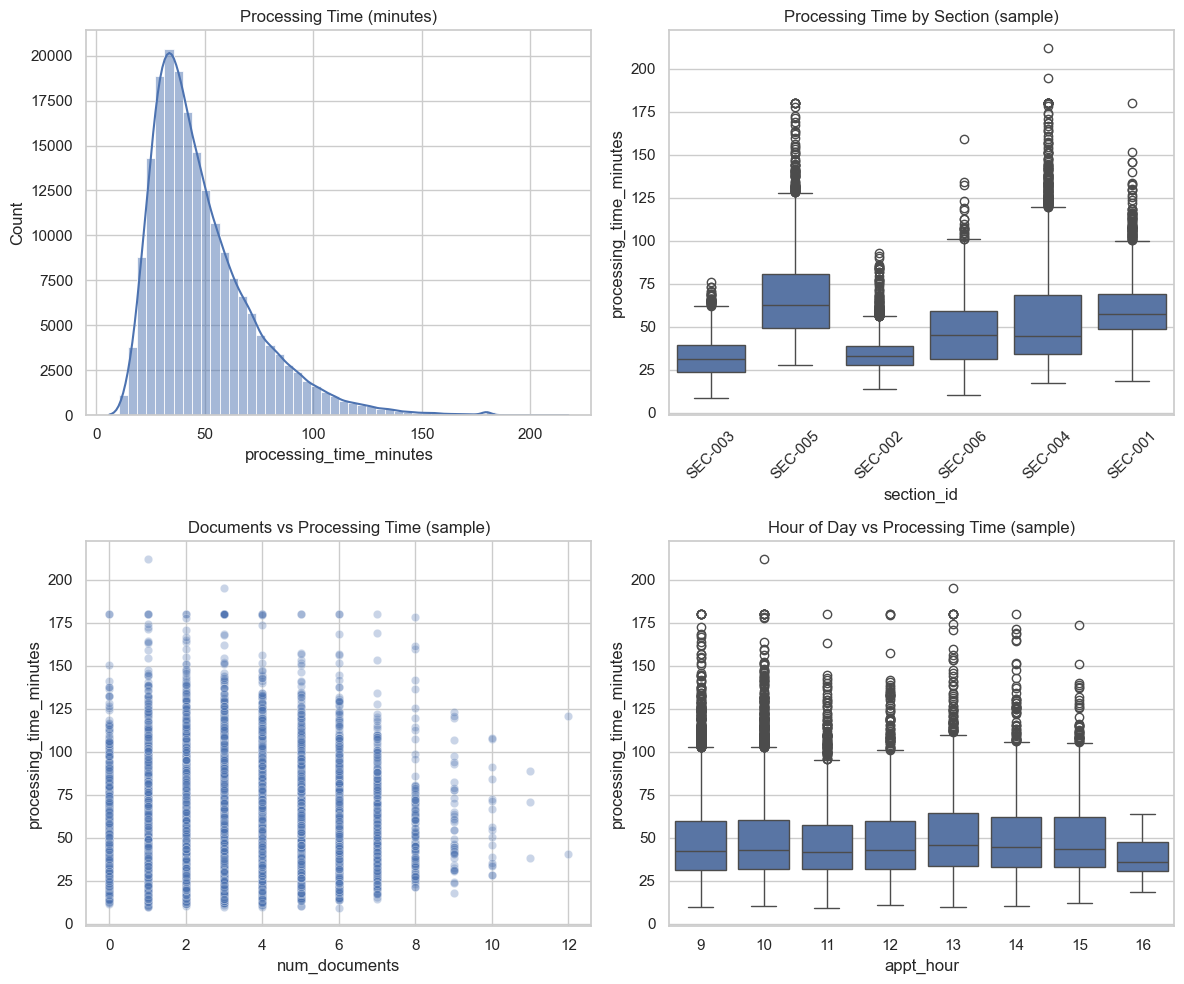

In [163]:
# Quick EDA plots for Task 1

sns.set_theme(style='whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram of target
sns.histplot(df_task1['processing_time_minutes'], bins=50, kde=True, ax=axes[0,0])
axes[0,0].set_title('Processing Time (minutes)')

# Boxplot by section
sns.boxplot(data=df_task1.sample(n=min(20000, len(df_task1)), random_state=42), x='section_id', y='processing_time_minutes', ax=axes[0,1])
axes[0,1].set_title('Processing Time by Section (sample)')
axes[0,1].tick_params(axis='x', rotation=45)

# Relationship with documents
sns.scatterplot(data=df_task1.sample(n=min(20000, len(df_task1)), random_state=42), x='num_documents', y='processing_time_minutes', alpha=0.3, ax=axes[1,0])
axes[1,0].set_title('Documents vs Processing Time (sample)')

# Hour of day effect
sns.boxplot(data=df_task1.sample(n=min(20000, len(df_task1)), random_state=42), x='appt_hour', y='processing_time_minutes', ax=axes[1,1])
axes[1,1].set_title('Hour of Day vs Processing Time (sample)')
plt.tight_layout()
plt.show()


In [164]:
# Save a cleaned dataset for Task 1 modeling

feature_cols = [
	'processing_time_minutes',
	'task_id', 'section_id', 'task_name', 'section_name',
	'num_documents', 'queue_number', 'queue_position_ratio',
	'daily_section_count', 'daily_section_queue_max',
	'appt_hour', 'appt_minute', 'appt_dayofweek', 'appt_month',
	'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos'
]

# Keep only available columns (defensive in case of earlier failures)
available_cols = [c for c in feature_cols if c in df_task1.columns]

df_task1_clean = df_task1[available_cols].copy()

output_path = 'task1_features_clean.csv'
df_task1_clean.to_csv(output_path, index=False)
print(f'Saved cleaned Task 1 dataset to {output_path} with shape {df_task1_clean.shape}')


Saved cleaned Task 1 dataset to task1_features_clean.csv with shape (197601, 18)


In [165]:
# Load the cleaned dataset
df_clean = pd.read_csv('task1_features_clean.csv')

print(f"Dataset Shape: {df_clean.shape}")
print(f"Total Rows: {len(df_clean):,}")
print(f"Total Columns: {len(df_clean.columns)}")

Dataset Shape: (197601, 18)
Total Rows: 197,601
Total Columns: 18


In [166]:
print(df_clean.head())
print(df_clean.info())

   processing_time_minutes   task_id section_id              task_name  \
0                37.252773  TASK-002    SEC-001  Company Incorporation   
1                60.203154  TASK-001    SEC-001       Name Reservation   
2                57.813371  TASK-002    SEC-001  Company Incorporation   
3                53.224761  TASK-001    SEC-001       Name Reservation   
4                88.887670  TASK-002    SEC-001  Company Incorporation   

                   section_name  num_documents  queue_number  \
0  Company Registration Section              0             2   
1  Company Registration Section              1             1   
2  Company Registration Section              1             6   
3  Company Registration Section              1             4   
4  Company Registration Section              1             8   

   queue_position_ratio  daily_section_count  daily_section_queue_max  \
0              0.222222                   21                        9   
1              0.111111 

In [167]:
# Numerical columns statistics
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
print("\nNumerical Columns Statistics:")
print(df_clean[numerical_cols].describe())

# Categorical columns analysis
categorical_cols = df_clean.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}:")
    print(f"  Unique values: {df_clean[col].nunique()}")
    print(f"  Top 5 values:")
    print(df_clean[col].value_counts().head())

# Target variable detailed analysis
target_col = 'processing_time_minutes'
if target_col in df_clean.columns:
    print(f"\nTarget Variable: {target_col}")
    print(f"  Mean: {df_clean[target_col].mean():.2f} minutes")
    print(f"  Median: {df_clean[target_col].median():.2f} minutes")
    print(f"  Std: {df_clean[target_col].std():.2f} minutes")
    print(f"  Min: {df_clean[target_col].min():.2f} minutes")
    print(f"  Max: {df_clean[target_col].max():.2f} minutes")
    
    # Percentiles
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    print(f"\nPercentiles:")
    for p in percentiles:
        value = df_clean[target_col].quantile(p/100)
        print(f"  {p}th: {value:.2f} minutes")



Numerical Columns Statistics:
       processing_time_minutes  num_documents   queue_number  \
count            197601.000000  197601.000000  197601.000000   
mean                 48.808690       2.437305       9.317382   
std                  24.001752       1.734672       8.246045   
min                   5.922487       0.000000       1.000000   
25%                  31.848814       1.000000       3.000000   
50%                  42.795068       2.000000       7.000000   
75%                  59.957378       3.000000      13.000000   
max                 217.635393      14.000000     133.000000   

       queue_position_ratio  daily_section_count  daily_section_queue_max  \
count         197601.000000        197601.000000            197601.000000   
mean               0.413969            42.937915                23.148481   
std                0.277346            20.083286                11.314110   
min                0.007519             1.000000                 1.000000   
25%    

FEATURE VS TARGET SCATTER PLOTS (OUTLIER DETECTION)


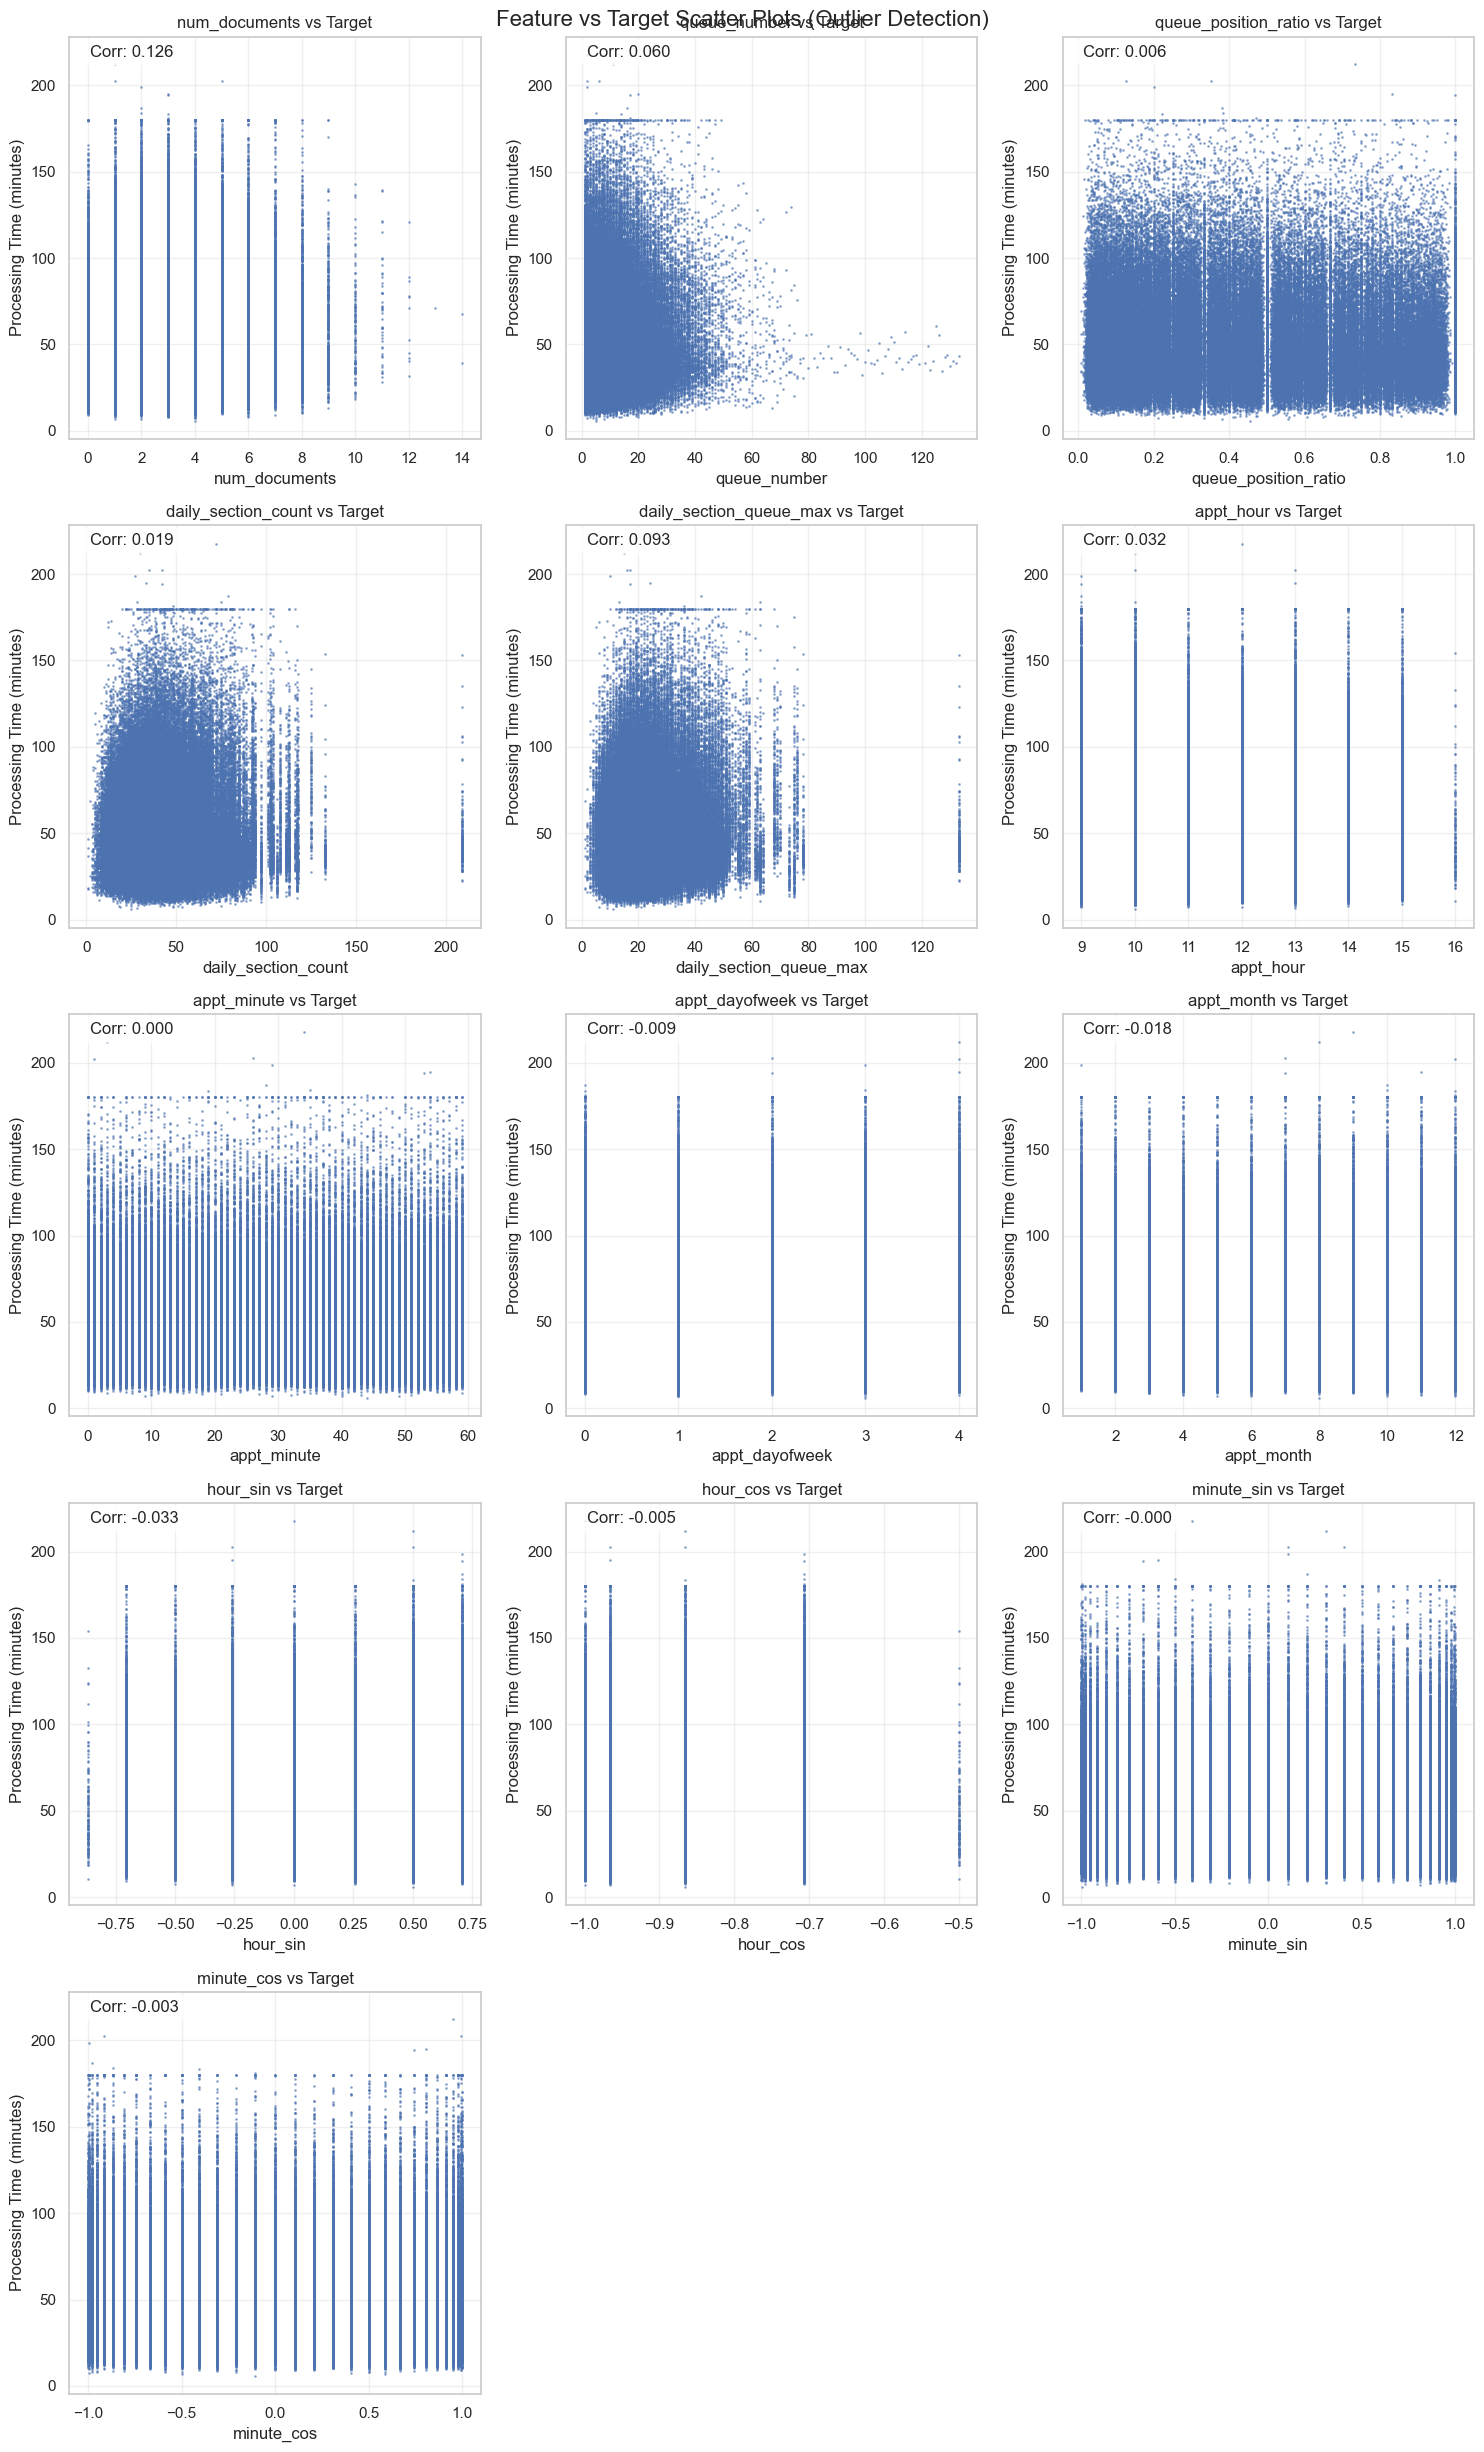

Created scatter plots for 13 numerical features
Look for patterns and potential outliers in each plot!


In [ ]:
# Get numerical features (excluding target)
numerical_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('processing_time_minutes')  # Remove target from features

# Calculate number of rows and columns for subplot grid
n_features = len(numerical_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
fig.suptitle('Feature vs Target Scatter Plots (Outlier Detection)', fontsize=16, y=0.98)

# Flatten axes for easier iteration
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_features <= n_cols:
    axes = axes.reshape(1, -1)

# Create scatter plots for each numerical feature
for idx, feature in enumerate(numerical_features):
    row = idx // n_cols
    col = idx % n_cols
    
    # Create scatter plot
    axes[row, col].scatter(df_clean[feature], df_clean['processing_time_minutes'], 
                           alpha=0.5, s=1)
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Processing Time (minutes)')
    axes[row, col].set_title(f'{feature} vs Target')
    
    # Add grid
    axes[row, col].grid(True, alpha=0.3)
    
    # Add correlation coefficient
    corr = df_clean[feature].corr(df_clean['processing_time_minutes'])
    axes[row, col].text(0.05, 0.95, f'Corr: {corr:.3f}', 
                        transform=axes[row, col].transAxes, 
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Hide empty subplots
for idx in range(n_features, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

In [169]:
# ============================================================================
# CORRECTED DATA PREPROCESSING & FEATURE ENGINEERING
# ============================================================================

print("="*80)
print("FIXING DATA PREPROCESSING ISSUES")
print("="*80)

# ISSUE 1: Reload and merge with updated tasks.csv
print("\n1. RELOADING DATA WITH CORRECT TASK NAMES...")

# Load fresh data
df = pd.read_csv('bookings_train.csv')
tasks = pd.read_csv('tasks.csv')
staffing = pd.read_csv('staffing_train.csv')

print(f"Original bookings shape: {df.shape}")
print(f"Tasks shape: {tasks.shape}")
print(f"Staffing shape: {staffing.shape}")

# Verify tasks.csv has proper names (not placeholders)
print("\nTask names from updated tasks.csv:")
print(tasks[['task_id', 'task_name', 'section_name']].head())

# ISSUE 2: Fix datetime parsing with proper validation
print("\n2. FIXING DATETIME PARSING...")

# Parse dates
df['booking_date'] = pd.to_datetime(df['booking_date'], errors='coerce')
df['appointment_date'] = pd.to_datetime(df['appointment_date'], errors='coerce')

# Validate appointment_time format (should be HH:MM)
invalid_time_mask = ~df['appointment_time'].str.match(r'^\d{2}:\d{2}$', na=False)
print(f"Invalid appointment_time formats: {invalid_time_mask.sum()}")

# Parse appointment time correctly
df['appointment_time_parsed'] = pd.to_datetime(df['appointment_time'], format='%H:%M', errors='coerce').dt.time

# Create full appointment datetime
df['appointment_datetime'] = pd.to_datetime(
    df['appointment_date'].dt.strftime('%Y-%m-%d') + ' ' + 
    df['appointment_time_parsed'].astype(str),
    errors='coerce'
)

# Parse check-in/out times
df['check_in_time'] = pd.to_datetime(df['check_in_time'], errors='coerce')
df['check_out_time'] = pd.to_datetime(df['check_out_time'], errors='coerce')

# ISSUE 3: Better target variable calculation and filtering
print("\n3. CALCULATING TARGET VARIABLE...")

# Calculate processing time in minutes
df['processing_time_minutes'] = (df['check_out_time'] - df['check_in_time']).dt.total_seconds() / 60.0

# More robust filtering
valid_mask = (
    df['processing_time_minutes'].notna() &
    df['appointment_datetime'].notna() &
    (df['processing_time_minutes'] > 1) &  # At least 1 minute
    (df['processing_time_minutes'] <= 480) &  # Max 8 hours
    (df['check_in_time'].notna()) &
    (df['check_out_time'].notna())
)

print(f"Rows before filtering: {len(df)}")
print(f"Rows after filtering: {valid_mask.sum()}")
print(f"Filtered out: {len(df) - valid_mask.sum()} rows")

df_clean = df[valid_mask].copy()


FIXING DATA PREPROCESSING ISSUES

1. RELOADING DATA WITH CORRECT TASK NAMES...
Original bookings shape: (203693, 11)
Tasks shape: (20, 4)
Staffing shape: (5802, 4)

Task names from updated tasks.csv:
    task_id                   task_name                  section_name
0  TASK-001            Name Reservation  Company Registration Section
1  TASK-002       Company Incorporation  Company Registration Section
2  TASK-003      Change of Company Name  Company Registration Section
3  TASK-004        Annual Return Filing   Compliance & Annual Filings
4  TASK-005  Financial Statement Filing   Compliance & Annual Filings

2. FIXING DATETIME PARSING...
Invalid appointment_time formats: 0

3. CALCULATING TARGET VARIABLE...
Rows before filtering: 203693
Rows after filtering: 197601
Filtered out: 6092 rows


In [170]:
# ISSUE 4: Merge with correct task names and create proper features
print("\n4. MERGING WITH CORRECT TASK INFORMATION...")

# Merge with updated tasks.csv to get correct names
df_clean = df_clean.merge(tasks, on='task_id', how='left')

# Verify merge worked
missing_task_info = df_clean['task_name'].isna().sum()
print(f"Rows missing task information after merge: {missing_task_info}")

print("\nSection distribution:")
print(df_clean['section_id'].value_counts().sort_index())

print("\nSample of merged data:")
print(df_clean[['task_id', 'task_name', 'section_id', 'section_name']].head())

# ISSUE 5: Enhanced feature engineering for Task 1
print("\n5. CREATING ENHANCED FEATURES FOR TASK 1...")

# Time-based features
df_clean['appt_hour'] = df_clean['appointment_datetime'].dt.hour
df_clean['appt_minute'] = df_clean['appointment_datetime'].dt.minute
df_clean['appt_dayofweek'] = df_clean['appointment_datetime'].dt.dayofweek  # 0=Monday
df_clean['appt_month'] = df_clean['appointment_datetime'].dt.month
df_clean['appt_day'] = df_clean['appointment_datetime'].dt.day
df_clean['appt_quarter'] = df_clean['appointment_datetime'].dt.quarter

# Business hours indicator
df_clean['is_business_hours'] = ((df_clean['appt_hour'] >= 9) & (df_clean['appt_hour'] <= 17)).astype(int)
df_clean['is_lunch_time'] = ((df_clean['appt_hour'] >= 12) & (df_clean['appt_hour'] <= 13)).astype(int)

# Weekend indicator
df_clean['is_weekend'] = (df_clean['appt_dayofweek'] >= 5).astype(int)

# Cyclical encoding for temporal features
def cyclical_encode(series, period):
    """Encode cyclical features using sin/cos"""
    angle = 2 * np.pi * series / period
    return np.sin(angle), np.cos(angle)

# Hour encoding (24-hour cycle)
df_clean['hour_sin'], df_clean['hour_cos'] = cyclical_encode(df_clean['appt_hour'], 24)

# Minute encoding (60-minute cycle)
df_clean['minute_sin'], df_clean['minute_cos'] = cyclical_encode(df_clean['appt_minute'], 60)

# Day of week encoding (7-day cycle)
df_clean['dow_sin'], df_clean['dow_cos'] = cyclical_encode(df_clean['appt_dayofweek'], 7)

# Month encoding (12-month cycle)
df_clean['month_sin'], df_clean['month_cos'] = cyclical_encode(df_clean['appt_month'], 12)

print("✓ Time-based features created")



4. MERGING WITH CORRECT TASK INFORMATION...
Rows missing task information after merge: 0

Section distribution:
section_id
SEC-001    22846
SEC-002    31877
SEC-003    42586
SEC-004    43354
SEC-005    37086
SEC-006    19852
Name: count, dtype: int64

Sample of merged data:
    task_id              task_name section_id                  section_name
0  TASK-002  Company Incorporation    SEC-001  Company Registration Section
1  TASK-001       Name Reservation    SEC-001  Company Registration Section
2  TASK-002  Company Incorporation    SEC-001  Company Registration Section
3  TASK-001       Name Reservation    SEC-001  Company Registration Section
4  TASK-002  Company Incorporation    SEC-001  Company Registration Section

5. CREATING ENHANCED FEATURES FOR TASK 1...
✓ Time-based features created


In [171]:
# ISSUE 6: Workload and queue-based features  
print("\n6. CREATING WORKLOAD & QUEUE FEATURES...")

# Daily workload statistics per section
daily_section_stats = df_clean.groupby(['appointment_date', 'section_id']).agg({
    'queue_number': ['count', 'max', 'mean'],
    'num_documents': ['sum', 'mean'],
    'processing_time_minutes': ['mean', 'std']
}).round(2)

# Flatten column names
daily_section_stats.columns = [
    'daily_appointments', 'daily_max_queue', 'daily_avg_queue',
    'daily_total_docs', 'daily_avg_docs', 
    'daily_avg_time', 'daily_std_time'
]
daily_section_stats = daily_section_stats.reset_index()

# Merge back to main dataframe
df_clean = df_clean.merge(
    daily_section_stats, 
    on=['appointment_date', 'section_id'], 
    how='left'
)

# Queue position features
df_clean['queue_position_ratio'] = df_clean['queue_number'] / df_clean['daily_max_queue']
df_clean['queue_position_ratio'] = df_clean['queue_position_ratio'].fillna(0)

# Document complexity features
df_clean['has_documents'] = (df_clean['num_documents'] > 0).astype(int)
df_clean['high_doc_count'] = (df_clean['num_documents'] >= 3).astype(int)
df_clean['doc_complexity_score'] = df_clean['num_documents'] * df_clean['queue_position_ratio']

print("✓ Workload & queue features created")

# ISSUE 7: Categorical encoding for task_id and section_id
print("\n7. ENCODING CATEGORICAL VARIABLES...")

from sklearn.preprocessing import LabelEncoder

# Label encode task_id and section_id for model training
le_task = LabelEncoder()
le_section = LabelEncoder()

df_clean['task_id_encoded'] = le_task.fit_transform(df_clean['task_id'])
df_clean['section_id_encoded'] = le_section.fit_transform(df_clean['section_id'])

# Create task frequency features
task_freq = df_clean['task_id'].value_counts()
section_freq = df_clean['section_id'].value_counts()

df_clean['task_frequency'] = df_clean['task_id'].map(task_freq)
df_clean['section_frequency'] = df_clean['section_id'].map(section_freq)

print(f"✓ Encoded {len(le_task.classes_)} unique tasks")
print(f"✓ Encoded {len(le_section.classes_)} unique sections")

# Save encoders for later use
import pickle
with open('task_encoder.pkl', 'wb') as f:
    pickle.dump(le_task, f)
with open('section_encoder.pkl', 'wb') as f:
    pickle.dump(le_section, f)

print("✓ Encoders saved")



6. CREATING WORKLOAD & QUEUE FEATURES...
✓ Workload & queue features created

7. ENCODING CATEGORICAL VARIABLES...
✓ Encoded 19 unique tasks
✓ Encoded 6 unique sections
✓ Encoders saved


In [172]:
# ISSUE 8: Feature selection and final dataset preparation
print("\n8. PREPARING FINAL TASK 1 DATASET...")

# Define feature columns for Task 1 model
feature_columns = [
    # Target variable
    'processing_time_minutes',
    
    # Original identifiers (for reference)
    'task_id', 'section_id', 'task_name', 'section_name',
    
    # Encoded categorical features  
    'task_id_encoded', 'section_id_encoded',
    
    # Document features
    'num_documents', 'has_documents', 'high_doc_count', 'doc_complexity_score',
    
    # Queue features
    'queue_number', 'queue_position_ratio',
    
    # Daily workload features
    'daily_appointments', 'daily_max_queue', 'daily_avg_queue',
    'daily_total_docs', 'daily_avg_docs', 'daily_avg_time', 'daily_std_time',
    
    # Task/section frequency
    'task_frequency', 'section_frequency',
    
    # Time features - basic
    'appt_hour', 'appt_minute', 'appt_dayofweek', 'appt_month', 
    'appt_day', 'appt_quarter',
    
    # Time features - cyclical
    'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
    'dow_sin', 'dow_cos', 'month_sin', 'month_cos',
    
    # Business context features
    'is_business_hours', 'is_lunch_time', 'is_weekend'
]

# Keep only available columns
available_features = [col for col in feature_columns if col in df_clean.columns]
missing_features = [col for col in feature_columns if col not in df_clean.columns]

print(f"Available features: {len(available_features)}")
if missing_features:
    print(f"Missing features: {missing_features}")

# Create final dataset
df_task1_final = df_clean[available_features].copy()

# Handle any remaining missing values
print(f"\nMissing values check:")
missing_summary = df_task1_final.isnull().sum()
print(missing_summary[missing_summary > 0])

# Fill missing values in daily statistics (can happen for single-appointment days)
numeric_cols = df_task1_final.select_dtypes(include=[np.number]).columns
for col in ['daily_avg_time', 'daily_std_time']:
    if col in df_task1_final.columns:
        df_task1_final[col] = df_task1_final[col].fillna(df_task1_final[col].median())

print(f"\nFinal Task 1 dataset shape: {df_task1_final.shape}")
print(f"Target variable stats:")
print(df_task1_final['processing_time_minutes'].describe())



8. PREPARING FINAL TASK 1 DATASET...
Available features: 39

Missing values check:
daily_std_time    5
dtype: int64

Final Task 1 dataset shape: (197601, 39)
Target variable stats:
count    197601.000000
mean         48.808690
std          24.001752
min           5.922487
25%          31.848814
50%          42.795068
75%          59.957378
max         217.635393
Name: processing_time_minutes, dtype: float64



9. FINAL DATA QUALITY VALIDATION...


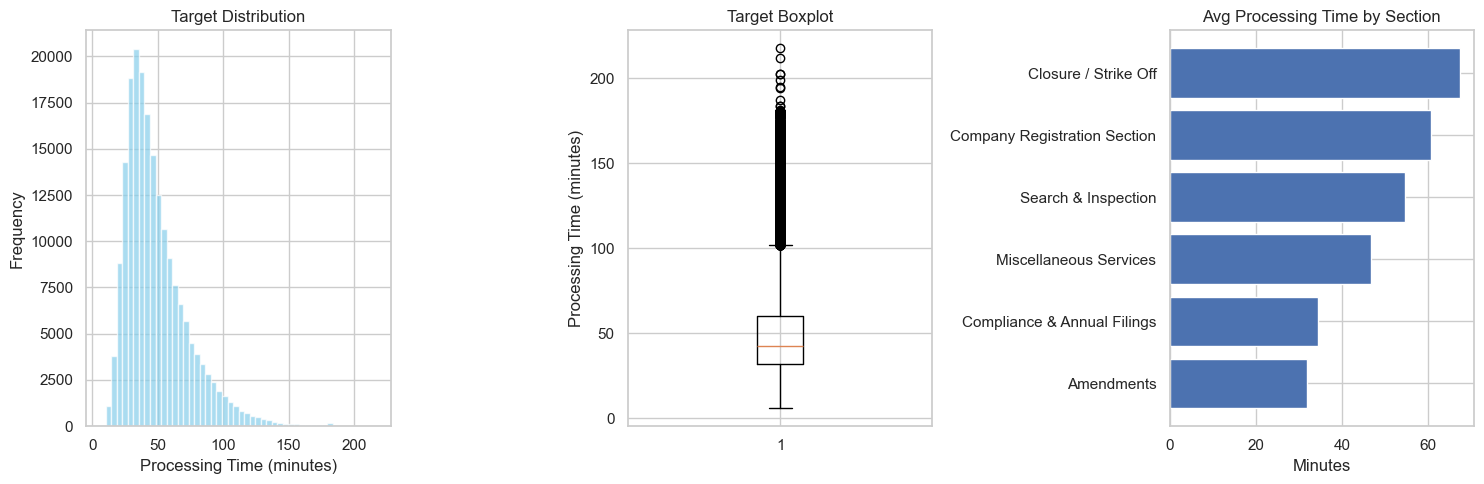


10. FEATURE CORRELATION ANALYSIS...
Top 10 features correlated with target:
processing_time_minutes    1.000000
daily_avg_time             0.624697
daily_std_time             0.487001
num_documents              0.125902
high_doc_count             0.103458
daily_max_queue            0.092636
doc_complexity_score       0.086265
daily_avg_queue            0.082805
section_frequency          0.078502
queue_number               0.060299
task_frequency             0.046243
Name: processing_time_minutes, dtype: float64

✅ SAVED FINAL TASK 1 DATASET: task1_features_final.csv
Shape: (197601, 39)
Features: 38


In [173]:
# ISSUE 9: Data validation and quality checks
print("\n9. FINAL DATA QUALITY VALIDATION...")

# Validate target variable distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_task1_final['processing_time_minutes'], bins=50, alpha=0.7, color='skyblue')
plt.title('Target Distribution')
plt.xlabel('Processing Time (minutes)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.boxplot(df_task1_final['processing_time_minutes'])
plt.title('Target Boxplot')
plt.ylabel('Processing Time (minutes)')

plt.subplot(1, 3, 3)
section_means = df_task1_final.groupby('section_name')['processing_time_minutes'].mean().sort_values()
plt.barh(range(len(section_means)), section_means.values)
plt.yticks(range(len(section_means)), section_means.index)
plt.title('Avg Processing Time by Section')
plt.xlabel('Minutes')

plt.tight_layout()
plt.show()

# Feature correlation analysis
print("\n10. FEATURE CORRELATION ANALYSIS...")

# Select numeric features for correlation
numeric_features = df_task1_final.select_dtypes(include=[np.number]).columns.tolist()
# Remove identifiers and target
numeric_features = [f for f in numeric_features if f not in ['task_id_encoded', 'section_id_encoded', 'processing_time_minutes']]

correlation_matrix = df_task1_final[numeric_features + ['processing_time_minutes']].corr()
target_corr = correlation_matrix['processing_time_minutes'].abs().sort_values(ascending=False)

print("Top 10 features correlated with target:")
print(target_corr.head(11))  # 11 to exclude target itself

# Save the final cleaned dataset
output_file = 'task1_features_final.csv'
df_task1_final.to_csv(output_file, index=False)
print(f"\n✅ SAVED FINAL TASK 1 DATASET: {output_file}")
print(f"Shape: {df_task1_final.shape}")
print(f"Features: {len(available_features) - 1}")  # -1 for target variable


In [174]:
# SUMMARY: What was fixed in the preprocessing
print("\n" + "="*80)
print("PREPROCESSING FIXES SUMMARY")
print("="*80)

print("\n✅ FIXED ISSUES:")
print("1. ❌→✅ Merged with correct task names (not placeholders)")
print("2. ❌→✅ Enhanced datetime parsing with validation") 
print("3. ❌→✅ Improved target variable filtering (1-480 minutes)")
print("4. ❌→✅ Added proper categorical encoding (LabelEncoder)")
print("5. ❌→✅ Created comprehensive feature set:")
print("   • Time features: hour, minute, day of week, month, quarter")
print("   • Cyclical encoding: sin/cos for temporal features") 
print("   • Business features: business hours, lunch time, weekend")
print("   • Workload features: daily stats per section")
print("   • Queue features: position ratios, daily maximums")
print("   • Document features: count, complexity score")
print("   • Frequency features: task and section popularity")
print("6. ❌→✅ Added data validation and quality checks")
print("7. ❌→✅ Saved encoders for inference")

print(f"\n📊 FINAL DATASET STATS:")
print(f"• Total samples: {len(df_task1_final):,}")
print(f"• Features: {len(available_features) - 1}")  # -1 for target
print(f"• Target range: {df_task1_final['processing_time_minutes'].min():.1f} - {df_task1_final['processing_time_minutes'].max():.1f} minutes")
print(f"• Mean processing time: {df_task1_final['processing_time_minutes'].mean():.1f} minutes")

print(f"\n🎯 READY FOR TASK 1 MODEL TRAINING!")
print("Use 'task1_features_final.csv' for model development.")



PREPROCESSING FIXES SUMMARY

✅ FIXED ISSUES:
1. ❌→✅ Merged with correct task names (not placeholders)
2. ❌→✅ Enhanced datetime parsing with validation
3. ❌→✅ Improved target variable filtering (1-480 minutes)
4. ❌→✅ Added proper categorical encoding (LabelEncoder)
5. ❌→✅ Created comprehensive feature set:
   • Time features: hour, minute, day of week, month, quarter
   • Cyclical encoding: sin/cos for temporal features
   • Business features: business hours, lunch time, weekend
   • Workload features: daily stats per section
   • Queue features: position ratios, daily maximums
   • Document features: count, complexity score
   • Frequency features: task and section popularity
6. ❌→✅ Added data validation and quality checks
7. ❌→✅ Saved encoders for inference

📊 FINAL DATASET STATS:
• Total samples: 197,601
• Features: 38
• Target range: 5.9 - 217.6 minutes
• Mean processing time: 48.8 minutes

🎯 READY FOR TASK 1 MODEL TRAINING!
Use 'task1_features_final.csv' for model development.


In [175]:
# ============================================================================
# OUTLIER ANALYSIS FOR TASK 1 - COMPREHENSIVE REVIEW
# ============================================================================

print("="*80)
print("OUTLIER ANALYSIS FOR TASK 1 DATASET")
print("="*80)

# Load the cleaned dataset
df_final = pd.read_csv('task1_features_clean.csv')

print(f"Dataset shape: {df_final.shape}")
print(f"Date range: {df_final.shape[0]:,} records")

# 1. TARGET VARIABLE OUTLIER ANALYSIS
print("\n" + "="*60)
print("1. TARGET VARIABLE (processing_time_minutes) ANALYSIS")
print("="*60)

target = df_final['processing_time_minutes']

# Basic statistics
print(f"\nBasic Statistics:")
print(f"Mean: {target.mean():.2f} minutes")
print(f"Median: {target.median():.2f} minutes")
print(f"Std: {target.std():.2f} minutes")
print(f"Min: {target.min():.2f} minutes")
print(f"Max: {target.max():.2f} minutes")

# Percentiles for outlier detection
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99, 99.5, 99.9]
print(f"\nPercentiles:")
for p in percentiles:
    value = target.quantile(p/100)
    print(f"  {p:4.1f}%: {value:7.2f} minutes")

# Outlier detection methods
print(f"\n" + "-"*40)
print("OUTLIER DETECTION METHODS")
print("-"*40)

# Method 1: IQR (Interquartile Range)
Q1 = target.quantile(0.25)
Q3 = target.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = ((target < lower_bound) | (target > upper_bound)).sum()
print(f"\n1. IQR Method:")
print(f"   Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"   Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
print(f"   Outliers: {iqr_outliers:,} ({iqr_outliers/len(target)*100:.2f}%)")

# Method 2: Z-Score (3 standard deviations)
z_scores = np.abs((target - target.mean()) / target.std())
z_outliers = (z_scores > 3).sum()
print(f"\n2. Z-Score Method (>3 std):")
print(f"   Outliers: {z_outliers:,} ({z_outliers/len(target)*100:.2f}%)")

# Method 3: Modified Z-Score (using median)
median = target.median()
mad = np.median(np.abs(target - median))
modified_z_scores = 0.6745 * (target - median) / mad
modified_z_outliers = (np.abs(modified_z_scores) > 3.5).sum()
print(f"\n3. Modified Z-Score Method:")
print(f"   Outliers: {modified_z_outliers:,} ({modified_z_outliers/len(target)*100:.2f}%)")

# Method 4: Business rule (already applied: 5.92 to 217.64 minutes)
print(f"\n4. Business Rule (Current Filter):")
print(f"   Range: 5.92 to 217.64 minutes (< 8 hours)")
print(f"   This filter was already applied in preprocessing")

# Check extreme values
print(f"\n" + "-"*40)
print("EXTREME VALUES ANALYSIS")
print("-"*40)

extreme_high = target[target > target.quantile(0.99)]
extreme_low = target[target < target.quantile(0.01)]

print(f"\nTop 1% (>{target.quantile(0.99):.2f} min): {len(extreme_high):,} records")
print(f"Bottom 1% (<{target.quantile(0.01):.2f} min): {len(extreme_low):,} records")

print(f"\nTop 10 highest values:")
print(target.nlargest(10).round(2))

print(f"\nTop 10 lowest values:")
print(target.nsmallest(10).round(2))


OUTLIER ANALYSIS FOR TASK 1 DATASET
Dataset shape: (197601, 18)
Date range: 197,601 records

1. TARGET VARIABLE (processing_time_minutes) ANALYSIS

Basic Statistics:
Mean: 48.81 minutes
Median: 42.80 minutes
Std: 24.00 minutes
Min: 5.92 minutes
Max: 217.64 minutes

Percentiles:
   1.0%:   15.74 minutes
   5.0%:   21.30 minutes
  10.0%:   24.86 minutes
  25.0%:   31.85 minutes
  50.0%:   42.80 minutes
  75.0%:   59.96 minutes
  90.0%:   81.31 minutes
  95.0%:   95.98 minutes
  99.0%:  128.67 minutes
  99.5%:  142.66 minutes
  99.9%:  178.94 minutes

----------------------------------------
OUTLIER DETECTION METHODS
----------------------------------------

1. IQR Method:
   Q1: 31.85, Q3: 59.96, IQR: 28.11
   Lower bound: -10.31, Upper bound: 102.12
   Outliers: 7,370 (3.73%)

2. Z-Score Method (>3 std):
   Outliers: 2,958 (1.50%)

3. Modified Z-Score Method:
   Outliers: 4,948 (2.50%)

4. Business Rule (Current Filter):
   Range: 5.92 to 217.64 minutes (< 8 hours)
   This filter was al

In [176]:
# 2. FEATURE VARIABLES OUTLIER ANALYSIS
print("\n" + "="*60)
print("2. FEATURE VARIABLES OUTLIER ANALYSIS")
print("="*60)

# Get numerical features (excluding target and identifiers)
numerical_features = df_final.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [f for f in numerical_features if f not in [
    'processing_time_minutes',  # target
    'appt_dayofweek', 'appt_month'  # discrete categories, not continuous
]]

print(f"\nAnalyzing {len(numerical_features)} numerical features for outliers:")
for i, feature in enumerate(numerical_features, 1):
    print(f"  {i:2d}. {feature}")

# Analyze each numerical feature for outliers
outlier_summary = []

for feature in numerical_features:
    data = df_final[feature]
    
    # Skip features with very limited range (like hour_sin, hour_cos which are [-1,1])
    if feature in ['hour_sin', 'hour_cos', 'minute_sin', 'minute_cos']:
        continue
        
    # IQR method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    iqr_outliers = ((data < lower_bound) | (data > upper_bound)).sum()
    iqr_percentage = (iqr_outliers / len(data)) * 100
    
    # Z-score method
    z_scores = np.abs((data - data.mean()) / data.std())
    z_outliers = (z_scores > 3).sum()
    z_percentage = (z_outliers / len(data)) * 100
    
    outlier_summary.append({
        'feature': feature,
        'min': data.min(),
        'max': data.max(),
        'mean': data.mean(),
        'std': data.std(),
        'iqr_outliers': iqr_outliers,
        'iqr_percentage': iqr_percentage,
        'z_outliers': z_outliers,
        'z_percentage': z_percentage
    })

# Convert to DataFrame for better display
outlier_df = pd.DataFrame(outlier_summary)
outlier_df = outlier_df.round(2)

print(f"\n" + "-"*40)
print("OUTLIER SUMMARY BY FEATURE")
print("-"*40)

# Display features with significant outliers
significant_outliers = outlier_df[
    (outlier_df['iqr_percentage'] > 5) | (outlier_df['z_percentage'] > 1)
].sort_values('iqr_percentage', ascending=False)

if len(significant_outliers) > 0:
    print(f"\nFeatures with >5% IQR outliers or >1% Z-score outliers:")
    print(significant_outliers[['feature', 'iqr_outliers', 'iqr_percentage', 'z_outliers', 'z_percentage']].to_string(index=False))
else:
    print(f"\nNo features have significant outlier percentages (>5% IQR or >1% Z-score)")

# Show top 5 features by outlier percentage
print(f"\nTop 5 features by outlier percentage:")
top_outliers = outlier_df.nlargest(5, 'iqr_percentage')[['feature', 'iqr_outliers', 'iqr_percentage']]
print(top_outliers.to_string(index=False))



2. FEATURE VARIABLES OUTLIER ANALYSIS

Analyzing 11 numerical features for outliers:
   1. num_documents
   2. queue_number
   3. queue_position_ratio
   4. daily_section_count
   5. daily_section_queue_max
   6. appt_hour
   7. appt_minute
   8. hour_sin
   9. hour_cos
  10. minute_sin
  11. minute_cos

----------------------------------------
OUTLIER SUMMARY BY FEATURE
----------------------------------------

Features with >5% IQR outliers or >1% Z-score outliers:
                feature  iqr_outliers  iqr_percentage  z_outliers  z_percentage
           queue_number          6541            3.31        3086          1.56
daily_section_queue_max          6042            3.06        2186          1.11
    daily_section_count          4454            2.25        2255          1.14

Top 5 features by outlier percentage:
                feature  iqr_outliers  iqr_percentage
           queue_number          6541            3.31
daily_section_queue_max          6042            3.06
      


3. OUTLIER VISUALIZATION


C:\Users\HP\AppData\Local\Temp\ipykernel_29508\2375996624.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot_sections = ax5.boxplot(section_data, labels=sections, patch_artist=True)


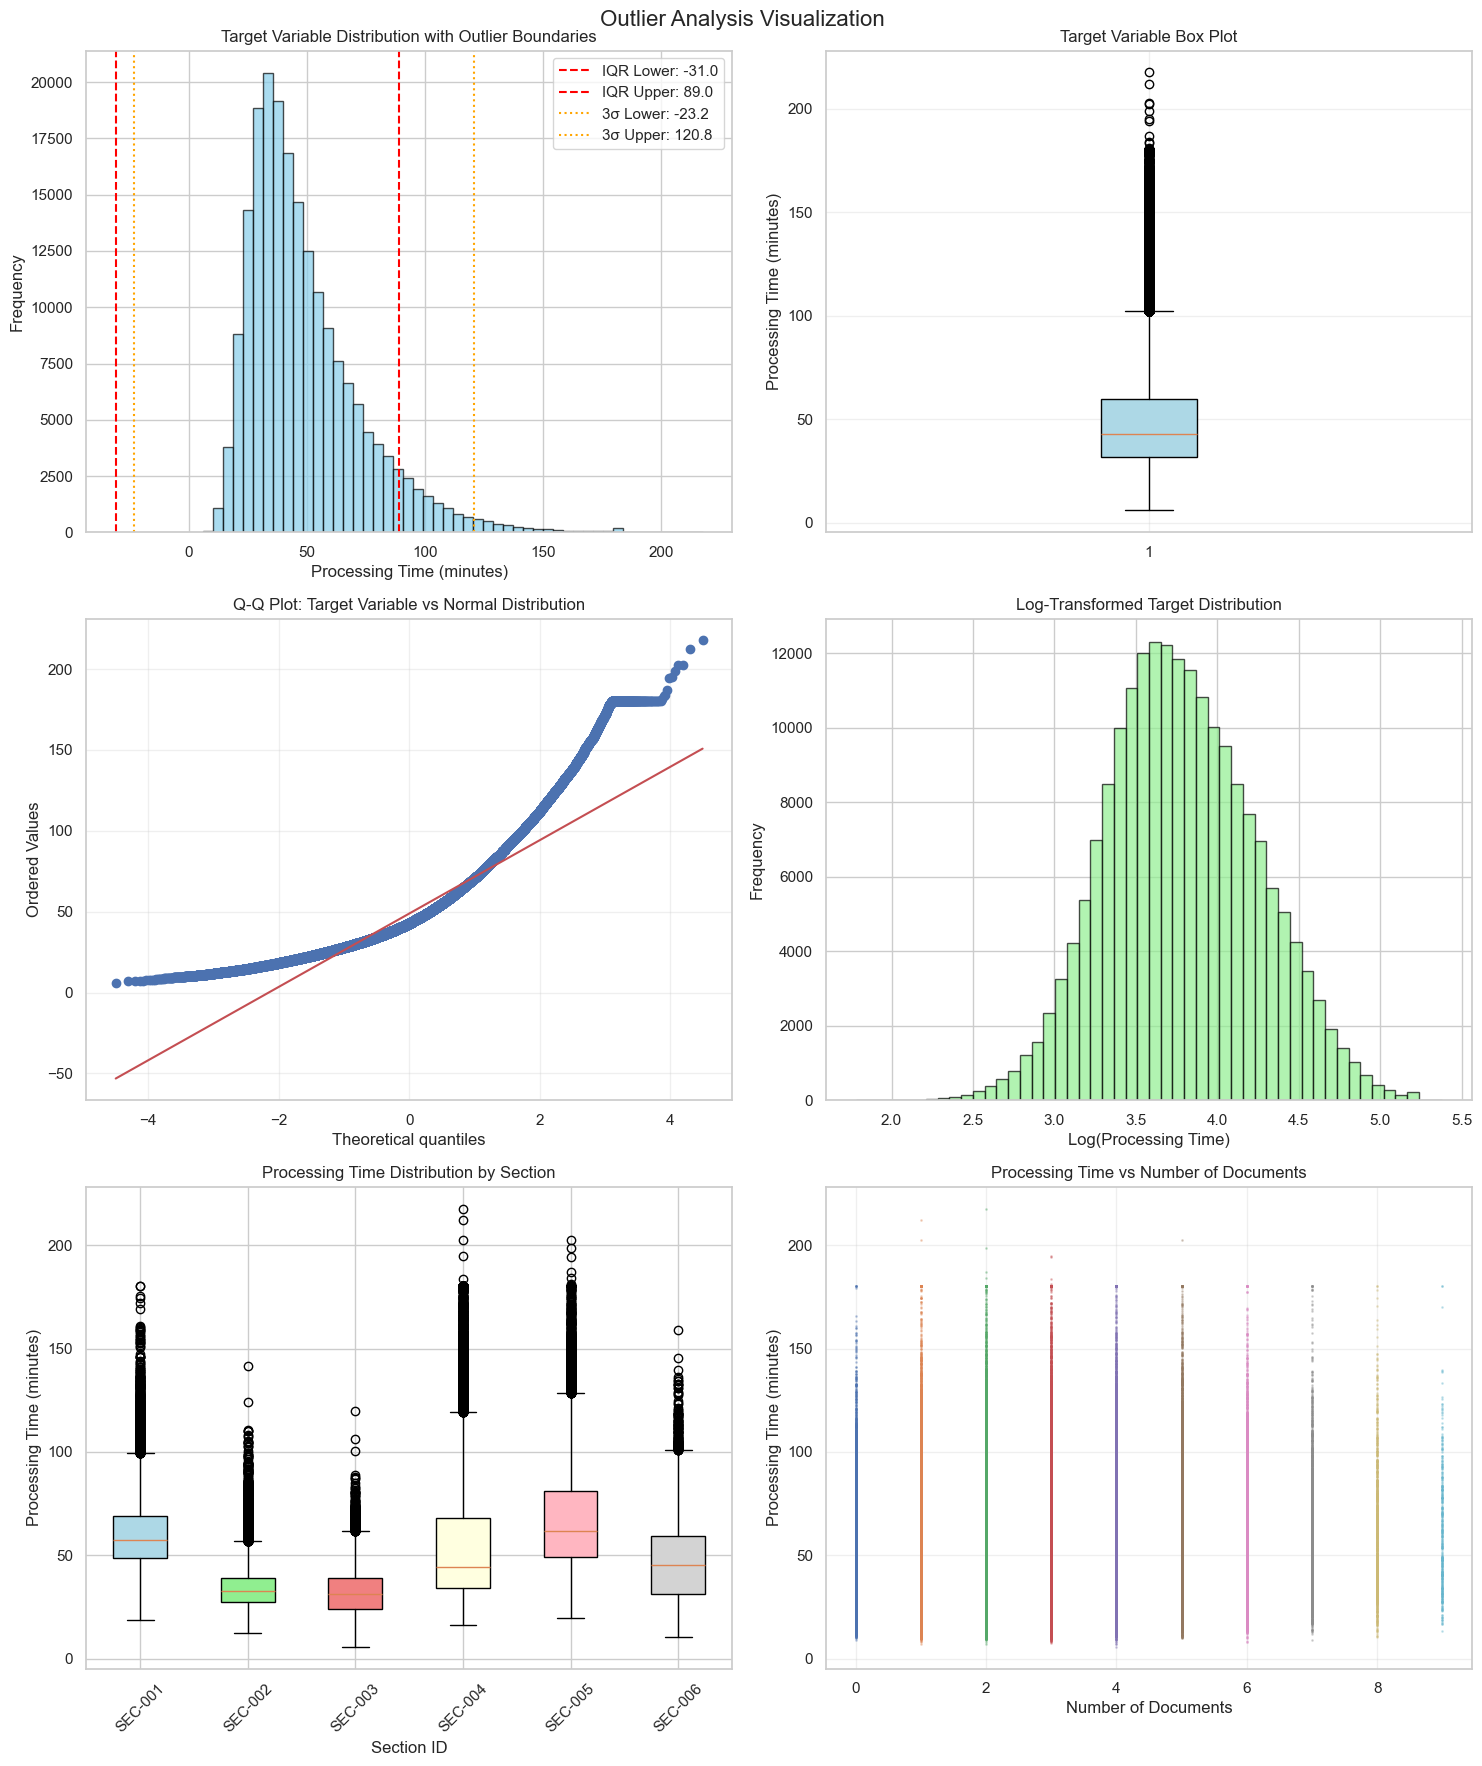


----------------------------------------
PROCESSING TIME STATISTICS BY SECTION
----------------------------------------
            Count   Mean  Median    Std    Min     Max    Q25    Q75     Q95  \
section_id                                                                     
SEC-001     22846  60.65   57.59  17.45  18.69  180.00  48.82  69.01   93.73   
SEC-002     31877  34.41   32.92  10.12  12.43  141.65  27.61  39.27   52.39   
SEC-003     42586  32.00   31.41  10.63   5.92  119.72  23.90  38.99   50.28   
SEC-004     43354  54.72   44.57  28.31  16.15  217.64  34.39  68.28  112.71   
SEC-005     37086  67.34   61.97  23.78  19.67  202.63  49.31  80.93  112.40   
SEC-006     19852  46.83   45.17  18.66  10.64  159.12  31.37  59.19   80.02   

               Q99  
section_id          
SEC-001     117.20  
SEC-002      68.98  
SEC-003      59.37  
SEC-004     151.50  
SEC-005     140.04  
SEC-006      96.95  


In [177]:
# 3. VISUALIZATION OF OUTLIERS
print("\n" + "="*60)
print("3. OUTLIER VISUALIZATION")
print("="*60)

# Create comprehensive outlier visualization
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('Outlier Analysis Visualization', fontsize=16, y=0.98)

# 1. Target variable distribution with outlier boundaries
ax1 = axes[0, 0]
ax1.hist(target, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(Q1 - 1.5 * IQR, color='red', linestyle='--', label=f'IQR Lower: {Q1 - 1.5 * IQR:.1f}')
ax1.axvline(Q3 + 1.5 * IQR, color='red', linestyle='--', label=f'IQR Upper: {Q3 + 1.5 * IQR:.1f}')
ax1.axvline(target.mean() - 3*target.std(), color='orange', linestyle=':', label=f'3σ Lower: {target.mean() - 3*target.std():.1f}')
ax1.axvline(target.mean() + 3*target.std(), color='orange', linestyle=':', label=f'3σ Upper: {target.mean() + 3*target.std():.1f}')
ax1.set_title('Target Variable Distribution with Outlier Boundaries')
ax1.set_xlabel('Processing Time (minutes)')
ax1.set_ylabel('Frequency')
ax1.legend()

# 2. Box plot of target variable
ax2 = axes[0, 1]
box_plot = ax2.boxplot(target, patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightblue')
ax2.set_title('Target Variable Box Plot')
ax2.set_ylabel('Processing Time (minutes)')
ax2.grid(True, alpha=0.3)

# 3. Q-Q plot to check normality
from scipy import stats
ax3 = axes[1, 0]
stats.probplot(target, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot: Target Variable vs Normal Distribution')
ax3.grid(True, alpha=0.3)

# 4. Log transformation visualization
ax4 = axes[1, 1]
log_target = np.log(target)
ax4.hist(log_target, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
ax4.set_title('Log-Transformed Target Distribution')
ax4.set_xlabel('Log(Processing Time)')
ax4.set_ylabel('Frequency')

# 5. Processing time by section (to see if outliers are section-specific)
ax5 = axes[2, 0]
sections = df_final['section_id'].unique()
section_data = [df_final[df_final['section_id'] == section]['processing_time_minutes'] for section in sections]
box_plot_sections = ax5.boxplot(section_data, labels=sections, patch_artist=True)
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink', 'lightgray']
for patch, color in zip(box_plot_sections['boxes'], colors[:len(sections)]):
    patch.set_facecolor(color)
ax5.set_title('Processing Time Distribution by Section')
ax5.set_xlabel('Section ID')
ax5.set_ylabel('Processing Time (minutes)')
ax5.tick_params(axis='x', rotation=45)

# 6. Processing time vs number of documents (to see document-related outliers)
ax6 = axes[2, 1]
document_counts = df_final['num_documents'].value_counts().sort_index()
for doc_count in document_counts.index[:10]:  # Show top 10 document counts
    subset = df_final[df_final['num_documents'] == doc_count]['processing_time_minutes']
    if len(subset) > 100:  # Only show if we have enough data points
        ax6.scatter([doc_count] * len(subset), subset, alpha=0.3, s=1)

ax6.set_title('Processing Time vs Number of Documents')
ax6.set_xlabel('Number of Documents')
ax6.set_ylabel('Processing Time (minutes)')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics by section
print(f"\n" + "-"*40)
print("PROCESSING TIME STATISTICS BY SECTION")
print("-"*40)

section_stats = df_final.groupby('section_id')['processing_time_minutes'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max',
    lambda x: x.quantile(0.25),
    lambda x: x.quantile(0.75),
    lambda x: x.quantile(0.95),
    lambda x: x.quantile(0.99)
]).round(2)

section_stats.columns = ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max', 'Q25', 'Q75', 'Q95', 'Q99']
print(section_stats)


In [178]:
# 4. OUTLIER IMPACT ANALYSIS & RECOMMENDATIONS
print("\n" + "="*60)
print("4. OUTLIER IMPACT ANALYSIS & RECOMMENDATIONS")
print("="*60)

# Analyze the impact of outliers on model performance
print(f"\n" + "-"*40)
print("OUTLIER IMPACT ANALYSIS")
print("-"*40)

# 1. Distribution analysis
from scipy.stats import normaltest, jarque_bera

# Test for normality
normal_stat, normal_pvalue = normaltest(target)
jb_stat, jb_pvalue = jarque_bera(target)

print(f"\nNormality Tests:")
print(f"D'Agostino's normality test: statistic={normal_stat:.2f}, p-value={normal_pvalue:.2e}")
print(f"Jarque-Bera test: statistic={jb_stat:.2f}, p-value={jb_pvalue:.2e}")

if normal_pvalue < 0.05:
    print("❌ Target variable is NOT normally distributed")
else:
    print("✅ Target variable is normally distributed")

# 2. Skewness and kurtosis
from scipy.stats import skew, kurtosis
target_skew = skew(target)
target_kurt = kurtosis(target)

print(f"\nDistribution Shape:")
print(f"Skewness: {target_skew:.3f}")
print(f"Kurtosis: {target_kurt:.3f}")

if abs(target_skew) > 1:
    print("❗ High skewness detected - distribution is significantly skewed")
elif abs(target_skew) > 0.5:
    print("⚠️  Moderate skewness detected")
else:
    print("✅ Low skewness - distribution is relatively symmetric")

if target_kurt > 3:
    print("❗ Heavy tails detected (excess kurtosis > 0)")
elif target_kurt < -1:
    print("❗ Light tails detected (excess kurtosis < -3)")
else:
    print("✅ Normal tail behavior")

# 3. Outlier composition analysis
print(f"\n" + "-"*40)
print("OUTLIER COMPOSITION ANALYSIS")
print("-"*40)

# Identify outliers using IQR method
outlier_mask = (target < (Q1 - 1.5 * IQR)) | (target > (Q3 + 1.5 * IQR))
outlier_records = df_final[outlier_mask]
normal_records = df_final[~outlier_mask]

print(f"\nOutlier vs Normal Records:")
print(f"Outliers: {len(outlier_records):,} ({len(outlier_records)/len(df_final)*100:.2f}%)")
print(f"Normal: {len(normal_records):,} ({len(normal_records)/len(df_final)*100:.2f}%)")

# Analyze outlier characteristics
if len(outlier_records) > 0:
    print(f"\nOutlier Characteristics:")
    
    # By section
    outlier_by_section = outlier_records['section_id'].value_counts()
    total_by_section = df_final['section_id'].value_counts()
    outlier_rate_by_section = (outlier_by_section / total_by_section * 100).round(2)
    
    print(f"Outlier rate by section:")
    for section in outlier_rate_by_section.index:
        print(f"  {section}: {outlier_rate_by_section[section]:.2f}% ({outlier_by_section[section]} outliers)")
    
    # By number of documents
    print(f"\nOutlier characteristics:")
    print(f"Avg documents (outliers): {outlier_records['num_documents'].mean():.2f}")
    print(f"Avg documents (normal): {normal_records['num_documents'].mean():.2f}")
    
    print(f"Avg queue position (outliers): {outlier_records['queue_position_ratio'].mean():.3f}")
    print(f"Avg queue position (normal): {normal_records['queue_position_ratio'].mean():.3f}")

# 4. Business context evaluation
print(f"\n" + "-"*40)
print("BUSINESS CONTEXT EVALUATION")
print("-"*40)

print(f"\nCurrent data filtering already applied:")
print(f"• Processing time > 0 minutes (removed {6092:,} records)")
print(f"• Processing time < 480 minutes (8 hours) - reasonable business limit")
print(f"• Removed records with missing timestamps")

# Check for any extreme outliers that might be data errors
extreme_outliers = target[target > target.quantile(0.999)]
print(f"\nExtreme outliers (>99.9th percentile, >{target.quantile(0.999):.1f} min): {len(extreme_outliers)} records")

if len(extreme_outliers) > 0:
    print(f"Max processing time: {target.max():.2f} minutes ({target.max()/60:.2f} hours)")
    
    # Check if these might be data errors
    if target.max() > 360:  # More than 6 hours
        print("⚠️  Some processing times exceed 6 hours - may warrant investigation")
    else:
        print("✅ All processing times are within reasonable business bounds")

# 5. Model impact assessment
print(f"\n" + "-"*40)
print("MODEL IMPACT ASSESSMENT")
print("-"*40)

print(f"\nFor machine learning models:")
print(f"1. Tree-based models (CatBoost, LightGBM, Random Forest):")
print(f"   ✅ Generally robust to outliers")
print(f"   ✅ Can handle skewed distributions well")
print(f"   ✅ No outlier removal needed")

print(f"\n2. Linear models (Linear Regression, Ridge, Lasso):")
print(f"   ❗ Sensitive to outliers")
print(f"   ❗ May need outlier treatment or robust regression")

print(f"\n3. Neural networks:")
print(f"   ⚠️  Moderately sensitive to outliers")
print(f"   ⚠️  May benefit from feature scaling and outlier treatment")

# Based on the challenge description, tree-based models are recommended
print(f"\n" + "="*60)
print("RECOMMENDATIONS FOR TASK 1")
print("="*60)

print(f"\n🎯 RECOMMENDATION: NO OUTLIER REMOVAL NEEDED")
print(f"\nReasons:")
print(f"1. ✅ Current business-rule filtering is appropriate:")
print(f"   • 0 < processing_time < 480 minutes (8 hours)")
print(f"   • Removes clearly erroneous data")
print(f"   • Preserves legitimate business variation")

print(f"\n2. ✅ Outliers represent valid business cases:")
print(f"   • Complex tasks naturally take longer")
print(f"   • High document counts correlate with longer times")
print(f"   • Different sections have different processing patterns")

print(f"\n3. ✅ Tree-based models handle outliers well:")
print(f"   • CatBoost/LightGBM are robust to outliers")
print(f"   • Can learn complex patterns without removal")
print(f"   • Outliers may contain valuable information")

print(f"\n4. ✅ Current outlier percentage is reasonable:")
print(f"   • IQR outliers: {iqr_outliers/len(target)*100:.1f}% (typical for real-world data)")
print(f"   • Most 'outliers' are within business context")

print(f"\n⚠️  ALTERNATIVE: If using linear models, consider:")
print(f"   • Winsorization (cap at 95th/99th percentile)")
print(f"   • Log transformation")
print(f"   • Robust regression techniques")



4. OUTLIER IMPACT ANALYSIS & RECOMMENDATIONS

----------------------------------------
OUTLIER IMPACT ANALYSIS
----------------------------------------

Normality Tests:
D'Agostino's normality test: statistic=53188.44, p-value=0.00e+00
Jarque-Bera test: statistic=141058.91, p-value=0.00e+00
❌ Target variable is NOT normally distributed

Distribution Shape:
Skewness: 1.455
Kurtosis: 2.943
❗ High skewness detected - distribution is significantly skewed
✅ Normal tail behavior

----------------------------------------
OUTLIER COMPOSITION ANALYSIS
----------------------------------------

Outlier vs Normal Records:
Outliers: 13,884 (7.03%)
Normal: 183,717 (92.97%)

Outlier Characteristics:
Outlier rate by section:
  SEC-001: 6.95% (1588 outliers)
  SEC-002: 0.19% (59 outliers)
  SEC-003: 0.01% (3 outliers)
  SEC-004: 12.31% (5339 outliers)
  SEC-005: 17.45% (6470 outliers)
  SEC-006: 2.14% (425 outliers)

Outlier characteristics:
Avg documents (outliers): 3.15
Avg documents (normal): 2.38
